In [2]:
from google.colab import files
uploaded = files.upload()

Saving movies_metadata.csv to movies_metadata.csv


In [490]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv(io.BytesIO(uploaded['movies_metadata.csv']))
# Dataset is now stored in a Pandas Dataframe

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [491]:
df.shape

(45466, 24)

Me quedo solo con revenues positivos (pierdo 38k registros de 45k)

In [492]:
df = df[df.revenue > 0]

In [493]:
(df.status != 'Released').sum(), (df.adult != 'False').sum(), (df.video == True).sum()

(13, 0, 0)

Siendo que hay tan poca variabilidad en los valores de video, status y adult  columnas las quito. Tambien saco vote average, vote count, budget, popularity, title y overview

In [494]:
df = df[['belongs_to_collection', 'genres',
       'imdb_id', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime']]

####Feature: belongs_to_collection

Hago a los nulls o na de la columna belongs_to_collection = 0


In [495]:
df['belongs_to_collection'].fillna(0, inplace = True)

Hay 751 colecciones distintas... Voy a implementar una variable binaria. Pertences o no a una colección.

In [496]:
import ast
def collection_from_dict(x):
  if x != 0:
   #convert string to dictionary
    res = ast.literal_eval(x) 
    #return just the name of the collection
    return 1
  return 0
df['collection'] = df.belongs_to_collection.apply(lambda x: collection_from_dict(x))

#Elimino la columna vieja
df.drop(columns = 'belongs_to_collection', inplace = True)

In [497]:
pd.crosstab(index = df.collection, columns = 'count')

col_0,count
collection,
0,5925
1,1483


####Feature: genres

Hago una lista de los generos para luego aplicarle un MultiLabelBinarizer


In [498]:
df['genres'] = df.genres.apply(lambda x: [i['name']  for i in eval(x)])

In [499]:
from sklearn.preprocessing import MultiLabelBinarizer
genres = df['genres']
mlb = MultiLabelBinarizer()
genres_enc = pd.DataFrame(mlb.fit_transform(genres),columns=mlb.classes_, index=df.index)

In [500]:
generos = []
counts = []

for i in range(20):
  generos.append(genres_enc.columns[i])
  counts.append(genres_enc.iloc[:,i].sum())

#Genero un pd Series
gen_ser = pd.Series(counts, index = generos)
gen_ser.sort_values(ascending = False, inplace = True)

#Calculo el aporte de cada genero
cum_sum = gen_ser.values.cumsum()
total = gen_ser.values.sum()
prop = cum_sum / total

frame = pd.DataFrame({ 'Genre': gen_ser.index, 'Counts': gen_ser.values, 'Cumulative': cum_sum, 'Proportion Explained': prop })
frame.head(12)

,Genre,Counts,Cumulative,Proportion Explained
0,Drama,3683,3683,0.199135
1,Comedy,2607,6290,0.340092
2,Thriller,1872,8162,0.441308
3,Action,1736,9898,0.535172
4,Romance,1437,11335,0.612868
5,Adventure,1120,12455,0.673425
6,Crime,1086,13541,0.732144
7,Science Fiction,747,14288,0.772533
8,Horror,735,15023,0.812274
9,Family,678,15701,0.848932


Dado que con los primeros 12 generos conservo ~90% de los datos. Corto ahi.

In [501]:
genres_enc = genres_enc[['Action', 'Adventure', 'Comedy', 'Crime', 
                         'Drama', 'Family', 'Fantasy', 'Horror',
                         'Mystery', 'Romance', 'Science Fiction', 'Thriller']]
df = pd.concat([df, genres_enc], axis=1)

#Elimino la columna vieja
df.drop(columns = ['genres'], inplace = True)

####Feature: production_countries

Hago lo mismo que hice con genres con production_countries

In [502]:
df['production_countries'] = df.production_countries.apply(lambda x: [i['name']  for i in eval(x)])
s = df['production_countries']
prod_country = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)

In [503]:
paises = []
counts = []

for i in range(98):
  paises.append(prod_country.columns[i])
  counts.append(prod_country.iloc[:,i].sum())

#Genero un pd Series
pais_ser = pd.Series(counts, index = paises)
pais_ser.sort_values(ascending = False, inplace = True)

#Calculo el aporte de cada pais
cum_sum = pais_ser.values.cumsum()
total = pais_ser.values.sum()
prop = cum_sum / total

frame = pd.DataFrame({ 'Pais': pais_ser.index, 'Counts': pais_ser.values, 'Cumulative': cum_sum, 'Proportion Explained': prop })
frame.head(12)

,Pais,Counts,Cumulative,Proportion Explained
0,United States of America,5623,5623,0.568784
1,United Kingdom,917,6540,0.661542
2,France,576,7116,0.719806
3,Germany,412,7528,0.761481
4,Canada,323,7851,0.794153
5,India,220,8071,0.816407
6,Italy,162,8233,0.832794
7,Japan,160,8393,0.848978
8,Australia,148,8541,0.863949
9,Spain,139,8680,0.878009


Con el top 12 conservo ~90% de los datos. Corto ahi.

In [504]:
prod_country = prod_country[['United States of America', 'United Kingdom', 'France', 'Germany',
                             'Canada', 'India', 'Italy', 'Japan', 'Australia', 'Spain',
                             'Russia', 'China']]

#las agrego al df                            
df = pd.concat([df, prod_country], axis=1)

#elimino la columna antigua
df.drop(columns = ['production_countries'], inplace = True)

####Feature: original_language

In [505]:
#Genero un pd Series
languages = pd.crosstab(index = df.original_language, columns='counts')
languages.sort_values(by = 'counts',ascending = False, inplace = True)
languages.head()

col_0,counts
original_language,
en,6356
fr,201
hi,118
ru,109
es,95


In [506]:
#Genero un pd Series
languages = pd.crosstab(index = df.original_language, columns='counts')
languages.sort_values(by = 'counts',ascending = False, inplace = True)

#Calculo el aporte de cada lengua
cum_sum = languages.counts.cumsum()
total = languages.counts.sum()
prop = cum_sum / total

prop.head()

original_language
en    0.857991
fr    0.885124
hi    0.901053
ru    0.915767
es    0.928591
Name: counts, dtype: float64

Ingles (en) solo tiene ~87% de los datos. Me quedo solo con peliculas en ingles y luego dropeo el feature. 

In [507]:
df = df[df.original_language == 'en']
df.drop(columns = ['original_language'], inplace = True)

####Feature: production_companies

In [508]:
df['production_companies'] = df.production_companies.apply(lambda x: [i['name']  for i in eval(x)])
s = df['production_companies']
prod_company = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
len(prod_company.columns)

5703

Production companies tiene +5700 dimensiones, mientras lo dropeo del df, despues lo evaluamos...

In [509]:
df.drop(columns = ['production_companies'], inplace = True)

####Features: release_date y runtime

In [510]:
df.fillna(0, inplace= True)
df = df[df.runtime != 0]
df = df[df.release_date != 0]

##Runtime

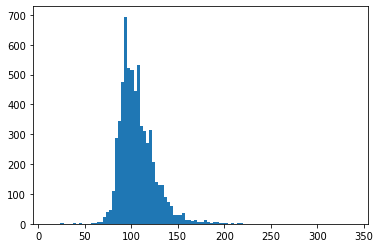

In [511]:
x = df.runtime
plt.hist(x, bins = 100)
plt.show()

Quito outliers y normalizo

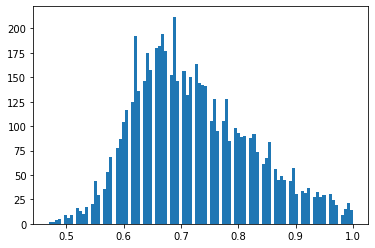

In [512]:
upper_lim = np.mean(df.runtime) + np.std(df.runtime)*2
lower_lim = np.mean(df.runtime) - np.std(df.runtime)*2

df = df[df.runtime > lower_lim]
df = df[df.runtime < upper_lim]

column_maxes = df.runtime.max()
df.runtime = df.runtime / column_maxes

x = df.runtime
plt.hist(x, bins = 100)
plt.show()

## Release date

Trabajo solo con el año de la pelicula

In [513]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = pd.DatetimeIndex(df['release_date']).year
df.drop(columns = ['release_date'], inplace = True)

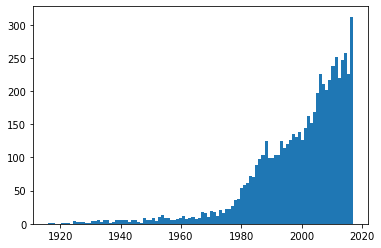

In [514]:
x = df.year
plt.hist(x, bins = 100)
plt.show()

Me quedo con las peliculas del 1985 en adelante


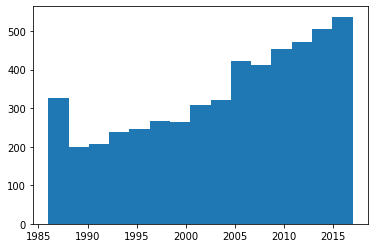

In [515]:
df = df[df.year > 1985]
x = df.year
plt.hist(x, bins = 15)
plt.show()

##Revenue

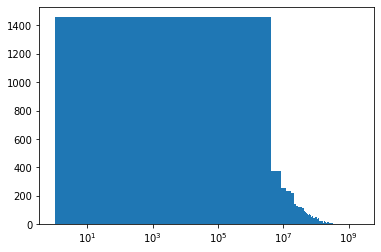

In [516]:
x = df.revenue
plt.hist(x, bins = 500)
plt.xscale('log')
plt.show()

Hay valores muy bajos que probablemente sean outliers. Filtro el primer decil del revenue.

In [517]:
df.revenue.quantile(.1)

187131.8

In [518]:
df = df[df.revenue > df.revenue.quantile(.1)]

Intento de darle forma gaussiana a la distribucion de los revenues aplicando el logaritmo

In [519]:
import math
def revenue_log(x):
  return math.log(x)

df['log_revenue'] = df.revenue.apply(lambda x: revenue_log(x))
df.drop(columns = ['revenue'], inplace = True)

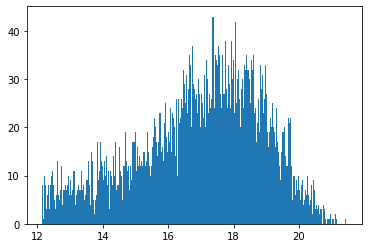

In [520]:
import matplotlib.pyplot as plt
x = df.log_revenue
plt.hist(x, bins = 300)
plt.show()

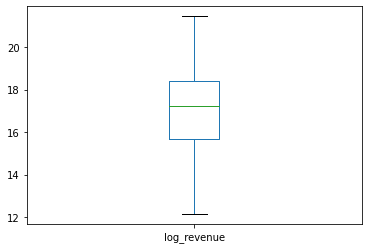

In [521]:
x.plot(kind = 'box')
plt.show()

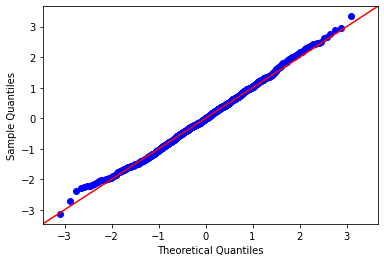

In [522]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab

x = norm.rvs(size=1000)
sm.qqplot(x, line='45')
pylab.show()

plt.show()

Tiene bastante pinta de normal salvo algunos valores muy bajos/altos

In [523]:
df.head()

,imdb_id,runtime,collection,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,United States of America,United Kingdom,France,Germany,Canada,India,Italy,Japan,Australia,Spain,Russia,China,year,log_revenue
0,tt0114709,0.558621,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1995,19.738573
1,tt0113497,0.717241,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1995,19.386893
3,tt0114885,0.875862,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1995,18.215526
4,tt0113041,0.731034,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1995,18.153832
8,tt0114576,0.731034,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1995,17.979850


## Armado de modelo predictivo

In [524]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

####Train and test set

In [525]:
train_df = df[df.year <= 2014]
test_df = df[df.year > 2014]

len(train_df), len(test_df), len(test_df) / len(train_df)

(4181, 478, 0.1143267160966276)

In [526]:
X_train = train_df[train_df.columns.difference(['year', 'log_revenue', 'imdb_id'])]
y_train = train_df[['log_revenue']]

X_test = test_df[test_df.columns.difference(['year', 'log_revenue', 'imdb_id'])]
y_test = test_df[['log_revenue']]

####Modelos

Regresión Lineal

In [527]:
regr = LinearRegression()
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)

In [528]:
print('Mean Squared Error: %.2f' % mean_squared_error(y_test, predictions))
print('Coefficient of Determination R2: %.2f' % r2_score(y_test, predictions))

Mean Squared Error: 2.73
Coefficient of Determination R2: 0.39


In [529]:
regr.coef_

array([[ 3.31278972e-01,  3.54086921e-01,  3.94825131e-01,
         4.04993010e-02,  4.75338103e-01,  4.36006641e-01,
         4.83787724e-02, -5.23845012e-01,  1.09533618e+00,
         4.17254729e-01,  8.30888078e-04,  1.54544145e-01,
        -7.84114344e-02, -8.10444168e-02, -1.98269373e-01,
        -3.76701214e-01,  2.59657755e-01,  2.12538021e-01,
        -3.76928887e-01,  9.41563869e-04,  1.72531670e-01,
         2.66843142e-01,  6.21995711e-02,  1.29160259e+00,
         1.13698452e+00,  6.91217108e+00]])

Árbol de Decisión

In [530]:
from sklearn.tree import DecisionTreeRegressor
rt = DecisionTreeRegressor(criterion = "mse", max_depth=7)
model_r = rt.fit(X_train, y_train)
y_pred = model_r.predict(X_test)

In [531]:
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of Determination R2: %.2f" % r2_score(y_test, y_pred))

Mean Squared Error: 3.10
Coefficient of Determination R2: 0.31


In [532]:
for importance, name in sorted(zip(rt.feature_importances_, X_train.columns),reverse=True):
  print (name, importance)

runtime 0.2869709628820763
collection 0.2786885656892998
United States of America 0.1378231846566236
Family 0.08632631034120007
Drama 0.060650624510623495
Action 0.03211909952242194
Horror 0.01809082150742261
Fantasy 0.01746490790222117
Comedy 0.016971780626590605
France 0.012139597563097324
Adventure 0.011438751586086184
United Kingdom 0.01026422672449244
Romance 0.009457155961791943
Germany 0.007046826828530474
Mystery 0.004069352555382951
Canada 0.003753446122193278
Science Fiction 0.0016248604092595697
Thriller 0.0015880541675620044
Crime 0.0015214193699266325
Italy 0.0007756493713952518
Australia 0.0005304351537260735
China 0.00042073784238828014
Japan 0.0002632287056881436
Spain 0.0
Russia 0.0
India 0.0


##Armo pipeline

Abrimos el csv e importamos algunas librerias

In [453]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd 
import numpy as np
import io

In [454]:
df = pd.read_csv(io.BytesIO(uploaded['movies_metadata.csv']))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###Pre-processing

####Revenue:
1. Quitamos valores menores o iguales a 0.
2. Filtramos el 5% de los valores mas bajos para evitar errores de tipeo.
3. Normalizamos aplicando el logaritmo.

In [455]:
df = df[df.revenue > 0]
df = df[df.revenue > df.revenue.quantile(.05)]

import math
def revenue_log(x):
  return math.log(x)

df['revenue'] = df.revenue.apply(lambda x: revenue_log(x))

####Runtime:
1. Sacamos valores nulos
2. Sacamos valores que esten a mas o menos de 2 desviaciones estandar de la media.

In [456]:
df.fillna(0, inplace= True)
df = df[df.runtime != 0]
upper_lim = np.mean(df.runtime) + np.std(df.runtime)*2
lower_lim = np.mean(df.runtime) - np.std(df.runtime)*2

df = df[df.runtime > lower_lim]
df = df[df.runtime < upper_lim]

####Release Date:
1. Convertimos a tipo de dato datetime.
2. Nos quedamos solo con el año.
3. Filtramos todas aquellas peliculas anteriores al 1985

In [457]:
#Convierto la fecha a datetime y me quedo solo con el año
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = pd.DatetimeIndex(df['release_date']).year
df = df[df.year > 1985]
df.drop(columns = ['release_date'], inplace = True)

#### Géneros, Países y Colecciones:
1. Convertimos los diccionarios a listas, quedandonos solo con el valor que nos interesa (name).
2. En el caso de colecciones dado que hay >700 colecctions con frecuencias bajas la convertimos en un tipo de dato binario. 1 si es parte de una coleccion, 0 caso contrario.

In [458]:
#Desarmo diccionarios y convierto en listas

#Generos
df['genres'] = df.genres.apply(lambda x: [i['name']  for i in eval(x)])

#Paises
df['production_countries'] = df.production_countries.apply(lambda x: [i['name']  for i in eval(x)])

#Colecciones
df['belongs_to_collection'].fillna(0, inplace = True)
import ast
def collection_from_dict(x):
  if x != 0:
   #convert string to dictionary
    res = ast.literal_eval(x) 
    #return just the name of the collection
    return 1
  return 0
df['belongs_to_collection'] = df.belongs_to_collection.apply(lambda x: collection_from_dict(x))


###Feature Selection:
1. Elegimos que variables dropear del modelo.

In [459]:
df=df.drop(columns = ['adult','budget','homepage','id','original_title',
                     'overview','popularity','poster_path','production_companies',
                     'spoken_languages','status', 'tagline', 'title', 'video',
                     'vote_average','vote_count'], axis=1)


###Train and test split:
1. Cortamos por año (2014) dado que queremos que el modelo aprenda a predecir películas del futuro.

In [460]:
#Train and test split
train_df = df[df.year <= 2014]
test_df = df[df.year > 2014]
len(train_df), len(test_df), len(test_df) / len(train_df)

(6055, 647, 0.10685383980181667)

In [461]:
y_train = (train_df.revenue).values
y_test = (test_df.revenue).values

###Feature Engineering

Vamos a usar todo como listas de diccionarios para poder usar el ecosistema de sklearn de forma sencilla

In [463]:
train_docs = train_df.to_dict(orient='records')
test_docs = test_df.to_dict(orient='records')

In [487]:
train_docs[0], test_docs[0]

({'belongs_to_collection': 1,
  'genres': ['Animation', 'Comedy', 'Family'],
  'imdb_id': 'tt0114709',
  'original_language': 'en',
  'production_countries': ['United States of America'],
  'revenue': 19.7385732187406,
  'runtime': 81.0,
  'year': 1995},
 {'belongs_to_collection': 1,
  'genres': ['Action', 'Adventure', 'Thriller'],
  'imdb_id': 'tt2381249',
  'original_language': 'en',
  'production_countries': ['China', 'United States of America'],
  'revenue': 20.341024173461395,
  'runtime': 131.0,
  'year': 2015})

####Performance metrics:
1. Medimos el mean absolute percentage error (mape) y el r2 para el train y test set.

In [470]:
from sklearn.metrics import r2_score

def test_pipe(pipe):
    return {
        'train_r2': round(r2_score(y_train, pipe.predict(train_docs)),2),
        'train_mape' : round(np.mean(np.abs(percentage_error(np.asarray(y_train), np.asarray(pipe.predict(train_docs))))) * 100,2),
        'test_r2': round(r2_score(y_test, pipe.predict(test_docs)),2),
        'test_mape' : round(np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(pipe.predict(test_docs))))) * 100,2)
    }

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

####Feature Géneros:
1. Hacemos variables dummies
2. La agregamos al pipeline
3. Fiteamos y medimos el performance

In [465]:
from sklearn.base import BaseEstimator, TransformerMixin

class GenreDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({g: 1 for g in e['genres']})
        return res

In [466]:
GenreDummies().transform(train_docs[:10])

[{'Animation': 1, 'Comedy': 1, 'Family': 1},
 {'Adventure': 1, 'Family': 1, 'Fantasy': 1},
 {'Comedy': 1, 'Drama': 1, 'Romance': 1},
 {'Comedy': 1},
 {'Action': 1, 'Adventure': 1, 'Thriller': 1},
 {'Action': 1, 'Adventure': 1, 'Thriller': 1},
 {'Comedy': 1, 'Drama': 1, 'Romance': 1},
 {'Adventure': 1, 'Animation': 1, 'Family': 1},
 {'Action': 1, 'Adventure': 1},
 {'Drama': 1, 'Romance': 1}]

In [467]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

Armamos el pipeline, lo fiteamos y lo medimos

In [468]:
pipe = make_pipeline(
    GenreDummies(), DictVectorizer(sparse=False),  
    LinearRegression()
)

pipe.fit(train_docs, y_train);

In [469]:
pipe.predict(train_docs[:10])

array([17.47467699, 18.25461521, 15.96120399, 16.38470431, 17.68795974,
       17.68795974, 15.96120399, 18.00098863, 17.39918703, 15.81464072])

In [471]:
test_pipe(pipe)

{'test_mape': 12.91, 'test_r2': 0.2, 'train_mape': 10.57, 'train_r2': 0.16}

####Feature años:
1. Armamos una variable que indique hace cuantos años se filmo la pelicula.
2. La agregamos al pipeline, fiteamos y medimos el performance.

In [472]:
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin

class YearsAgo(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.now = datetime.now().year
        
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({'years_ago': self.now - int(e['year'])})
        return res

In [473]:
YearsAgo().transform(train_docs[150:160])

[{'years_ago': 28},
 {'years_ago': 26},
 {'years_ago': 26},
 {'years_ago': 27},
 {'years_ago': 27},
 {'years_ago': 27},
 {'years_ago': 27},
 {'years_ago': 29},
 {'years_ago': 27},
 {'years_ago': 27}]

In [474]:
from sklearn.pipeline import make_union

pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False))
    ),
    LinearRegression()
)

pipe.fit(train_docs, y_train);

In [475]:
test_pipe(pipe)

{'test_mape': 12.91, 'test_r2': 0.19, 'train_mape': 10.5, 'train_r2': 0.16}

####Feature países:
1. Armamos variables dummies.
2. La agregamos al pipeline, fiteamos y medimos el performance.

In [476]:
class CountryDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({g: 1 for g in e['production_countries']})
        return res

In [477]:
CountryDummies().transform(train_docs[:10])

[{'United States of America': 1},
 {'United States of America': 1},
 {'United States of America': 1},
 {'United States of America': 1},
 {'United States of America': 1},
 {'United Kingdom': 1, 'United States of America': 1},
 {'United States of America': 1},
 {'United States of America': 1},
 {'France': 1, 'Germany': 1, 'Italy': 1, 'United States of America': 1},
 {'United Kingdom': 1, 'United States of America': 1}]

In [479]:
from sklearn.pipeline import make_union

pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False)),
        make_pipeline(CountryDummies(), DictVectorizer(sparse=False))
    ),
    LinearRegression()
)

pipe.fit(train_docs, y_train);

In [480]:
test_pipe(pipe)

{'test_mape': 11.84, 'test_r2': 0.3, 'train_mape': 9.72, 'train_r2': 0.26}

####Feature runtime:
1. Calculamos el runtime máximo.
2. Normalizamos la variable dividiendola por el runtime máximo.
3. La añadimos al pipeline, lo fiteamos y medimos el performance.

In [481]:
max_runtime = df.runtime.max()

class Runtime(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({'runtime': e['runtime'] / max_runtime})
        return res



In [482]:
Runtime().transform(train_docs[:5])

[{'runtime': 0.54},
 {'runtime': 0.6933333333333334},
 {'runtime': 0.8466666666666667},
 {'runtime': 0.7066666666666667},
 {'runtime': 0.7066666666666667}]

#####Regresión Logística

In [483]:
pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False)),
        make_pipeline(CountryDummies(), DictVectorizer(sparse=False)),
        make_pipeline(Runtime(), DictVectorizer(sparse=False))        
    ),
    LinearRegression()
)

pipe.fit(train_docs, y_train);

In [484]:
test_pipe(pipe)

{'test_mape': 11.06, 'test_r2': 0.37, 'train_mape': 9.01, 'train_r2': 0.35}

#####Red Neuronal

In [485]:
from sklearn.neural_network import MLPRegressor

pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False)),
        make_pipeline(CountryDummies(), DictVectorizer(sparse=False)),
        make_pipeline(Runtime(), DictVectorizer(sparse=False))        
    ),
    MLPRegressor(random_state=21, max_iter=500)
)

pipe.fit(train_docs, y_train);

In [486]:
test_pipe(pipe)

{'test_mape': 11.19, 'test_r2': 0.32, 'train_mape': 8.24, 'train_r2': 0.44}